In [1]:
!pip install -r requirements.txt

In [2]:
import kagglehub
# path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
path = kagglehub.dataset_download("jangedoo/utkface-new")

/home/e20210007813/Bureau/ProjImage/face_filters/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import cv2
import os

In [5]:
# Load face detection classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [6]:
latent_dim = 128
image_size = 128
images = []

In [7]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not load image {img_path}. Skipping.")
        return []

    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(
        grey_img, scaleFactor=1.1, minNeighbors=5, minSize=(40,40)
    )

    crops = []
    for (x, y, w, h) in faces:
        x_max = min(img.shape[1], x + w)
        y_max = min(img.shape[0], y + h)
        x = max(0, x)
        y = max(0, y)

        if w <= 0 or h <= 0:
            continue

        im_cropped = img[y:y_max, x:x_max]
        if im_cropped.size == 0:
            continue

        im_cropped = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2RGB)
        im_cropped = cv2.resize(im_cropped, (image_size, image_size))
        im_cropped = im_cropped.astype("float32") / 255.0
        crops.append(im_cropped)

    return crops

In [ ]:
i = 0
numImg = 2000
for root, dirs, files in os.walk(path):
    for file in files:
        if i >= numImg:
            break
        if file.endswith(".jpg"):
            img_path = os.path.join(root, file)
            processed_crops = preprocess_image(img_path)
            if len(processed_crops) == 0:
                continue
            for crop in processed_crops:
                images.append(crop)
                i += 1
                if i >= numImg:
                    break

In [10]:
!pip show tensorflow

Name: tensorflow
Version: 2.20.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/e20210007813/Bureau/ProjImage/face_filters/.venv/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google_pasta, grpcio, h5py, keras, libclang, ml_dtypes, numpy, opt_einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing_extensions, wrapt
Required-by: 


In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

images = np.array(images)
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

print("Training shape:", x_train.shape)
print("Test shape:", x_test.shape)

Training shape: (1837, 128, 128, 3)
Test shape: (460, 128, 128, 3)


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input

2025-11-26 11:27:06.159679: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-26 11:27:10.730267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-26 11:27:29.495341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [13]:

from keras.saving import register_keras_serializable


# --- Residual Block ---
def residual_block(x, filters, strides=1):
    shortcut = x
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding="same")(shortcut)
    
    x = layers.Conv2D(filters, 3, strides=strides, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

# --- U-Net Encoder ---
def build_encoder(latent_dim):

    encoder_inputs = Input(shape=(128,128,3))

    # downsampling 1
    x = layers.Conv2D(16, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
    s1 = x   # 64x64
    
    # downsampling 2
    x = residual_block(x, 32, strides=2)  # 32x32
    s2 = x

    # downsampling 3
    x = residual_block(x, 64, strides=2)  # 16x16
    s3 = x

    # downsampling 4 / bottleneck
    x = residual_block(x, 128, strides=2) # 8x8 bottleneck feature map
    s4 = x  # final skip
    
    # flatten only after last skip
    x_flat = layers.Flatten()(x)
    x_flat = layers.Dense(256, activation="relu")(x_flat)

    z_mean = layers.Dense(latent_dim)(x_flat)
    z_log_var = layers.Dense(latent_dim)(x_flat)

    @register_keras_serializable()
    def sampling(args):
        mean, log_var = args
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    return Model(encoder_inputs, [z_mean, z_log_var, z, [s1, s2, s3, s4]], name="encoder")



In [ ]:
# from keras.saving import register_keras_serializable

# encoder_inputs = keras.Input(shape=(128, 128, 3))

# x = layers.Conv2D(16, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
# x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
# x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
# x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)

# x = layers.Flatten()(x)
# x = layers.Dense(256, activation="relu")(x)

# z_mean = layers.Dense(latent_dim)(x)
# z_log_var = layers.Dense(latent_dim)(x)


# @register_keras_serializable()
# def sampling(args):
#     mean, log_var = args
#     epsilon = tf.random.normal(shape=tf.shape(mean))
#     return mean + tf.exp(0.5 * log_var) * epsilon

# z = layers.Lambda(sampling)([z_mean, z_log_var])

# encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()


In [14]:
def build_decoder(latent_dim):

    # incoming inputs
    z_inputs = Input(shape=(latent_dim,))
    s1 = Input(shape=(64,64,16))     # earliest
    s2 = Input(shape=(32,32,32))
    s3 = Input(shape=(16,16,64))
    s4 = Input(shape=(8,8,128))      # bottleneck skip

    # bottleneck reconstruction
    x = layers.Dense(8*8*128, activation="relu")(z_inputs)
    x = layers.Reshape((8,8,128))(x)

    # ---------------------------------
    # FIRST: concat bottleneck (8×8)
    # ---------------------------------
    x = layers.Concatenate()([x, s4])
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    # ---------------------------------
    # UPSAMPLE TO 16×16
    # ---------------------------------
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, s3])
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    # ---------------------------------
    # UPSAMPLE TO 32×32
    # ---------------------------------
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, s2])
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)

    # ---------------------------------
    # UPSAMPLE TO 64×64
    # ---------------------------------
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, s1])
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)

    # ---------------------------------
    # UPSAMPLE TO 128×128 (no more skip maps)
    # ---------------------------------
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)

    outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)

    return Model([z_inputs, s1, s2, s3, s4], outputs, name="decoder")



In [15]:
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

I0000 00:00:1764152875.302359    5556 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7433 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

beta = 0.5
gamma = 0.1  # peso de la perceptual loss

# --- Preparar modelo VGG para perceptual loss ---
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))
vgg.trainable = False
layer_names = ['block3_conv3', 'block4_conv3']
vgg_outputs = [vgg.get_layer(name).output for name in layer_names]
vgg_model = Model(inputs=vgg.input, outputs=vgg_outputs)

def perceptual_loss(x_true, x_pred):
    # VGG espera imágenes en [0,255], actualmente tus imágenes están en [0,1]
    x_true_pp = preprocess_input(x_true * 255.0)
    x_pred_pp = preprocess_input(x_pred * 255.0)
    
    features_true = vgg_model(x_true_pp)
    features_pred = vgg_model(x_pred_pp)
    
    loss = 0
    for f_true, f_pred in zip(features_true, features_pred):
        loss += tf.reduce_mean(tf.square(f_true - f_pred))
    return loss

# --- Clase VAE ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, x):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, skips = self.encoder(x, training=True)
            reconstruction = self.decoder([z] + skips, training=True)

            # Reconstrucción MAE + SSIM
            mae = tf.reduce_mean(tf.abs(x - reconstruction), axis=[1,2,3])
            ssim = tf.clip_by_value(tf.image.ssim(x, reconstruction, max_val=1.0), 0.0, 1.0)
            ssim_loss = 1.0 - ssim
            recon_loss = tf.reduce_mean(mae + 0.5 * ssim_loss)

            # KL divergence
            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
            kl_loss = tf.reduce_mean(kl_loss)

            # Perceptual loss
            p_loss = perceptual_loss(x, reconstruction)

            total_loss = recon_loss + beta * kl_loss + gamma * p_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {"loss": total_loss,
                "reconstruction_loss": recon_loss,
                "kl_loss": kl_loss,
                "perceptual_loss": p_loss}

    def test_step(self, x):
        z_mean, z_log_var, z, skips = self.encoder(x, training=False)
        reconstruction = self.decoder([z] + skips, training=False)

        mae = tf.reduce_mean(tf.abs(x - reconstruction), axis=[1,2,3])
        ssim = tf.clip_by_value(tf.image.ssim(x, reconstruction, max_val=1.0), 0.0, 1.0)
        ssim_loss = 1.0 - ssim
        recon_loss = tf.reduce_mean(mae + 0.5 * ssim_loss)

        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        p_loss = perceptual_loss(x, reconstruction)
        total_loss = recon_loss + beta * kl_loss + gamma * p_loss

        return {"loss": total_loss,
                "reconstruction_loss": recon_loss,
                "kl_loss": kl_loss,
                "perceptual_loss": p_loss}

    def call(self, x):
        _, _, z, skips = self.encoder(x)
        return self.decoder([z] + skips)

In [17]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss=None)

In [18]:
class SaveEveryN(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 20 == 0:
            vae.build((None,) + x_train.shape[1:])
            print(f"\n🔽 Saving VAE on epoch {epoch+1}...")
            vae.encoder.save(f"../Models/Temp/vae_encoder_epoch_{epoch+1}.keras")
            vae.decoder.save(f"../Models/Temp/vae_decoder_epoch_{epoch+1}.keras")
            vae.save_weights(f'../Models/Temp/vae_weights_epoch_{epoch+1}.weights.h5')

In [19]:
# Train th   e vae
epochs = 20
batch_size = 32

history = vae.fit(
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test, None),
    callbacks=[SaveEveryN()]
)
vae.build((None,) + x_train.shape[1:])


Epoch 1/20


2025-11-26 11:28:39.503477: I external/local_xla/xla/service/service.cc:163] XLA service 0x7246ec024310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-26 11:28:39.503492: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-11-26 11:28:39.819169: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-26 11:28:40.237010: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-26 11:28:40.237119: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-26 11:28:40.237457: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-26 11:28:40.237535: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignor

 2/58 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - kl_loss: 10.3654 - loss: 17288.2568 - perceptual_loss: 172826.1875 - reconstruction_loss: 0.4553 

I0000 00:00:1764152938.040553    6634 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - kl_loss: 17.1394 - loss: 7474.9410 - perceptual_loss: 74660.8246 - reconstruction_loss: 0.2887

2025-11-26 11:29:02.304239: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-26 11:29:02.304259: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-26 11:29:02.304287: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-26 11:29:02.304298: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_3/Assert


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - kl_loss: 17.0713 - loss: 7406.7825 - perceptual_loss: 73979.6062 - reconstruction_loss: 0.2860

2025-11-26 11:29:11.064180: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-26 11:29:11.064234: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-26 11:29:11.064624: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-26 11:29:11.064669: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_3/Assert
2025-11-26 11:29:13.134289: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-26 11:29:13.134308: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-26 11:29:13.134338: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-26 11:29:13.134344: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator S

58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 308ms/step - kl_loss: 13.1912 - loss: 3521.7463 - perceptual_loss: 35150.1562 - reconstruction_loss: 0.1351 - val_kl_loss: 15.2798 - val_loss: 3316.2158 - val_perceptual_loss: 33084.5703 - val_reconstruction_loss: 0.1189
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - kl_loss: 12.4856 - loss: 1326.4083 - perceptual_loss: 13201.0635 - reconstruction_loss: 0.0592 - val_kl_loss: 13.5866 - val_loss: 1222.1548 - val_perceptual_loss: 12153.0459 - val_reconstruction_loss: 0.0569
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - kl_loss: 7.5968 - loss: 607.0494 - perceptual_loss: 6032.0703 - reconstruction_loss: 0.0440 - val_kl_loss: 8.0886 - val_loss: 692.7332 - val_perceptual_loss: 6886.4209 - val_reconstruction_loss: 0.0468
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - kl_loss: 4.2972 - loss: 499.3192 - perceptual_loss: 4971.2573 - reconstruction_loss: 0.0448 - val_kl_loss: 4.4611 - val_loss: 553.0615 - val_perceptual_loss: 5507.8652 - val_recon

In [20]:
vae.encoder.save( "../Models/vae_encoder.keras")
vae.decoder.save( "../Models/vae_decoder.keras")

vae.save_weights('../Models/vae_weights.weights.h5')

In [ ]:
# encoder = keras.models.load_model("../Models/vae_encoder_300epochs.keras", compile=False, safe_mode=False)
# decoder = keras.models.load_model("../Models/vae_decoder_300epochs.keras", compile=False, safe_mode=False)

# vae = VAE(encoder, decoder)

# vae.build((None,) + x_train.shape[1:])
# vae.load_weights("../Models/vae_weights_300epochs.weights.h5")

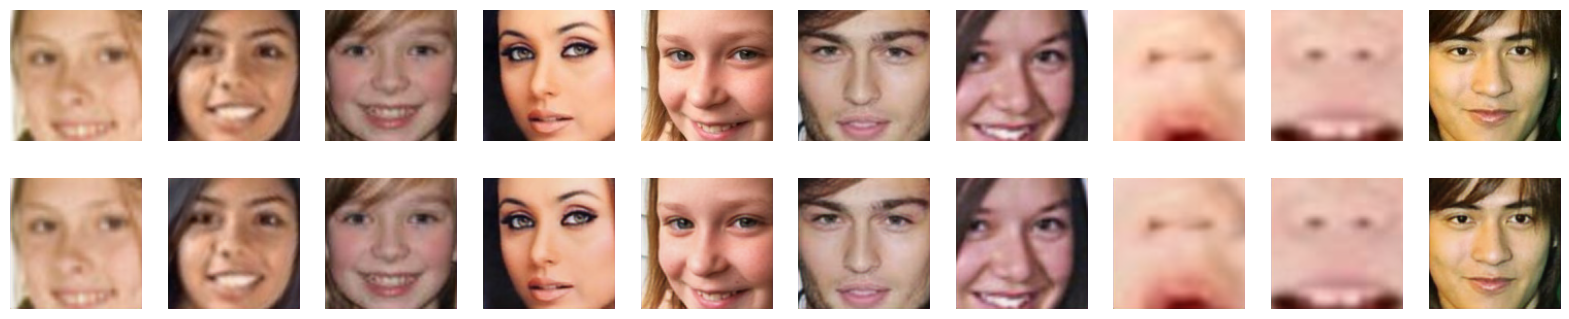

In [22]:
# Compare original and reconstructed images
import matplotlib.pyplot as plt

n = 10

# El encoder devuelve: z_mean, z_log_var, z
z_mean, z_log_var, z, split = vae.encoder(x_test[:n])
decoded_imgs = vae.decoder([z] + split)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.axis("off")

plt.show()

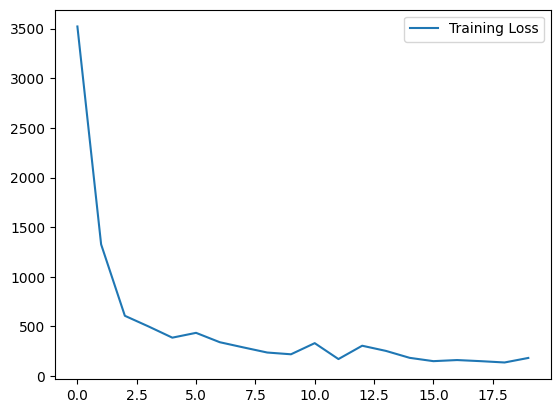

In [23]:
loss = history.history['loss']

epoch_range = range(epochs)

plt.plot(epoch_range, loss, label='Training Loss')
plt.legend()
plt.show()

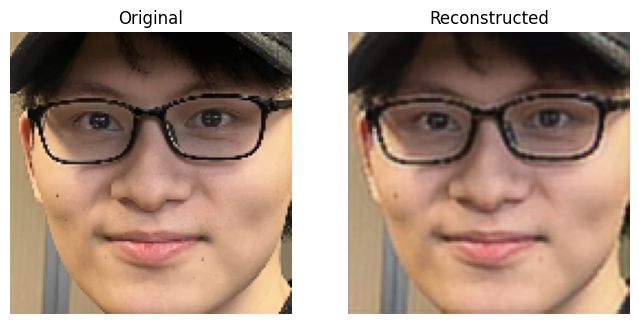

In [32]:
img_path = "../Images/XH.jpg"

# Preprocess
face = preprocess_image(img_path)[1]
face_batch = np.expand_dims(face, axis=0)  # shape (1, H, W, C)

# Encode & decode
z_mean, z_log_var, z, split= vae.encoder(face_batch)
decoded_imgs = vae.decoder([z] + split)  # still a batch of 1

# Plot original vs reconstructed
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(face)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(decoded_imgs[0])
plt.title("Reconstructed")
plt.axis("off")

plt.show()